# 09 - log AB - deep model building

**Objectives**
* **!!! log transformed AB plaque index !!!**
* perform regressions per level1 region on ROIx1 plaque proximity index
* train GBM / other regressors per stratum: `CX+KI->pp`, `BS+KI->pp`, etc..

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools
from numpy import ma  # masked array

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
from umap import UMAP

import lime 
from lime.lime_tabular import LimeTabularExplainer

import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")

* Gradient Boosting early stop monitor - let's put this here up front as we use it frequently..

In [2]:
class EarlyStopMonitor:

    def __init__(self, window_length=25):
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

---

## Load the data

In [3]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [4]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 170 ms, sys: 162 ms, total: 332 ms
Wall time: 190 ms


In [5]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 16.1 s, sys: 6.49 s, total: 22.6 s
Wall time: 22.6 s


In [6]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [7]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT']       = st_df['GT'].astype('category', copy=False)
st_df['age']      = st_df['age'].astype('category', copy=False)
st_df['age_GT']   = st_df['age_GT'].astype('category', copy=False)

In [8]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

* merge with satellite tables

In [9]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [10]:
final_meta_df = pd.read_csv('final_metadata_scores.tsv', sep='\t', index_col=0)
final_meta_df.index.name = 'spot_UID'
final_meta_df.reset_index(inplace=True)
final_meta_df = final_meta_df[final_meta_df['AB'].notna()][['spot_UID', 'AB']]

### Log transform AB index
* the AB index is very skewed, this is not ideal for ML algorithm to regress upon
* use a masked array to compute natural log of AB index

cfr. **Jaak Simm**:
> if it is not transformed, the skewness will result in the fact that larger (absolute) deviations will be focused by the model
so lot of focus will be put into these high end values

In [11]:
final_meta_df['log_AB'] = ma.log(final_meta_df['AB'].as_matrix())

* let's check the distributions after log transform
* much nicer (Gaussian-like)
* there is some bimodality going on (could be batch effect, to investigate)

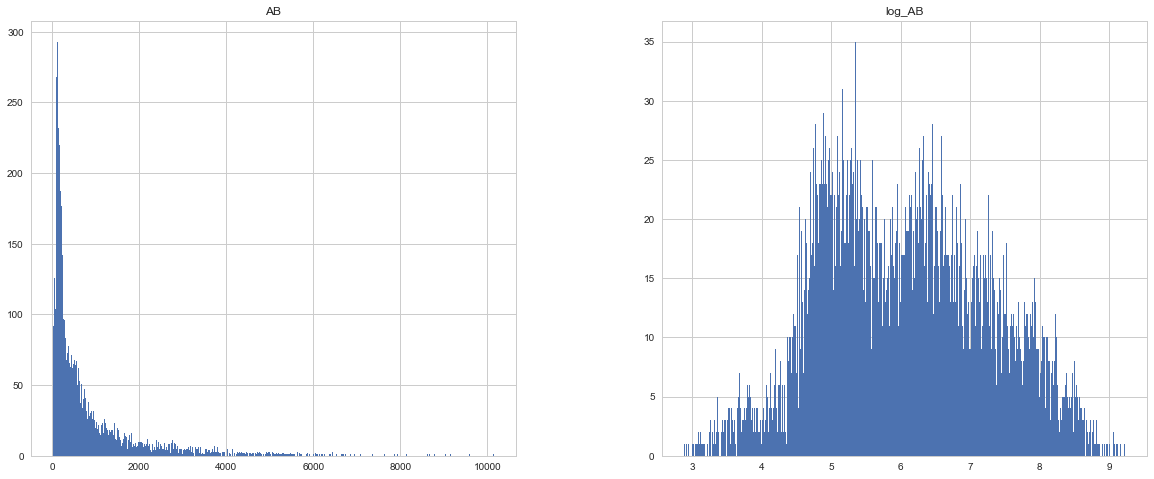

In [12]:
final_meta_df[final_meta_df['log_AB'] > 0][['AB', 'log_AB']].hist(bins=500, figsize=(20, 8))
plt.show()

In [13]:
full_df = st_df \
    .merge(region_levels_df, on='Region_predict') \
    .merge(final_meta_df, on='spot_UID')

In [14]:
expression_df = full_df[gene_columns]

In [15]:
expression_df.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,4.984943,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
1,2.982974,2.982974,2.982974,2.982974,6.827059,5.924174,2.982974,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
2,2.982974,2.982974,2.982974,2.982974,2.982974,5.609164,2.982974,2.982974,5.609164,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
3,2.982974,2.982974,2.982974,2.982974,7.661385,2.982974,2.982974,2.982974,5.157746,5.157746,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
4,2.982974,2.982974,2.982974,2.982974,6.738947,6.738947,2.982974,2.982974,2.982974,7.432553,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974


In [16]:
log_AB_df = full_df[['log_AB']]

In [17]:
# assert expression_df.shape == (10327, 46454) 
assert expression_df.shape == (10324, 46454)  # 3 less = damaged spots

---

## Boruta feature selection
* recompute the boruta feature selection step, regrssion onto the **log_AB** values.
* Boruta feature selection uses a RF regressor
* TODO: check out [RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

Using boruta, features compete against scrambled versions of themeselves in order to determine which variables display predictive power towards the target variable. One can consider this step as a coarse grained features selection step.

In [18]:
boruta_genes_log_AB_path = '08_results/boruta_genes_log_AB.tsv'

* perform the Boruta feature selection on **log_AB**
* guess: we'll get more features 
* A: yep.. from 155 to ~1100
* this result is more in correspondence with boruta classification on the GT feature, which also returns 1000+ candidate features

In [19]:
boruta_genes = list(pd.read_csv(boruta_genes_log_AB_path, sep='\t', header=None)[0])

In [20]:
# %%time
# boruta_selector = do_boruta()

In [21]:
# boruta_genes = gene_columns[boruta_selector.support_]

In [22]:
# pd.DataFrame(boruta_genes).to_csv(boruta_genes_log_AB_path, sep='\t', header=None, index=None)

* read from file

In [23]:
len(boruta_genes)

1108

---

# Spots by region and genotype

* Sets of spots per Level_01 region
* Region: CX, BS, HP, NA
* Genotype: WT, KI

In [24]:
level_01_regions = region_levels_df.Level_01.unique()
level_01_regions

array(['CX', 'NA', 'BS', 'HP'], dtype=object)

In [25]:
KI_region_sets = {}
WT_region_sets = {}
KI_WT_region_sets = {}

for level_01 in level_01_regions:
    KI_region_sets[level_01]    = full_df[(full_df['Level_01'] == level_01) & (full_df['GT'] == 'KI')]    
    WT_region_sets[level_01]    = full_df[(full_df['Level_01'] == level_01) & (full_df['GT'] == 'WT')]    
    KI_WT_region_sets[level_01] = full_df[(full_df['Level_01'] == level_01)]

---

# **-=[CX]=-**

In [26]:
CX_KI_WT_boruta = KI_WT_region_sets['CX'][boruta_genes]
CX_KI_WT_log_AB = KI_WT_region_sets['CX']['log_AB']
CX_GT           = KI_WT_region_sets['CX']['GT']

In [27]:
splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = list(splitter.split(CX_KI_WT_boruta, CX_KI_WT_log_AB, groups=CX_GT))[0]

In [28]:
CX_KI_WT_boruta_train = CX_KI_WT_boruta.iloc[train_idx]
CX_KI_WT_log_AB_train = CX_KI_WT_log_AB.iloc[train_idx]

CX_KI_WT_boruta_test = CX_KI_WT_boruta.iloc[test_idx]
CX_KI_WT_log_AB_test = CX_KI_WT_log_AB.iloc[test_idx]

CX_GT_train = CX_GT.iloc[train_idx]
CX_GT_test  = CX_GT.iloc[test_idx]

# GBM model that acts as the second filter, after the Boruta filtration step

In [29]:
stumps_sgbm = GradientBoostingRegressor(learning_rate=0.005, 
                                        n_estimators=10000, 
                                        max_features=0.1, 
                                        subsample=0.9, 
                                        random_state=42, 
                                        max_depth=1)

In [30]:
%%time
stumps_sgbm.fit(X=CX_KI_WT_boruta_train,  
                y=CX_KI_WT_log_AB_train,
                monitor=EarlyStopMonitor())

stopped after rounds: 4278
CPU times: user 41.5 s, sys: 32.6 ms, total: 41.5 s
Wall time: 41.5 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=1, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10000, presort='auto', random_state=42,
             subsample=0.9, verbose=0, warm_start=False)

In [31]:
feature_importances_df = pd.DataFrame({'gene': boruta_genes, 'importance': stumps_sgbm.feature_importances_}).sort_values(by='importance', ascending=False)
feature_importances_df.head(10)

,gene,importance
918,Sez6,0.070577
982,Tbx1,0.048609
423,Gm45212,0.043234
178,Cst7,0.037626
260,Fzd5,0.028511
195,Dao,0.027343
531,Hsh2d,0.026174
1074,mt-Atp6,0.022201
561,Kif15,0.021734
398,Gm26917,0.020566


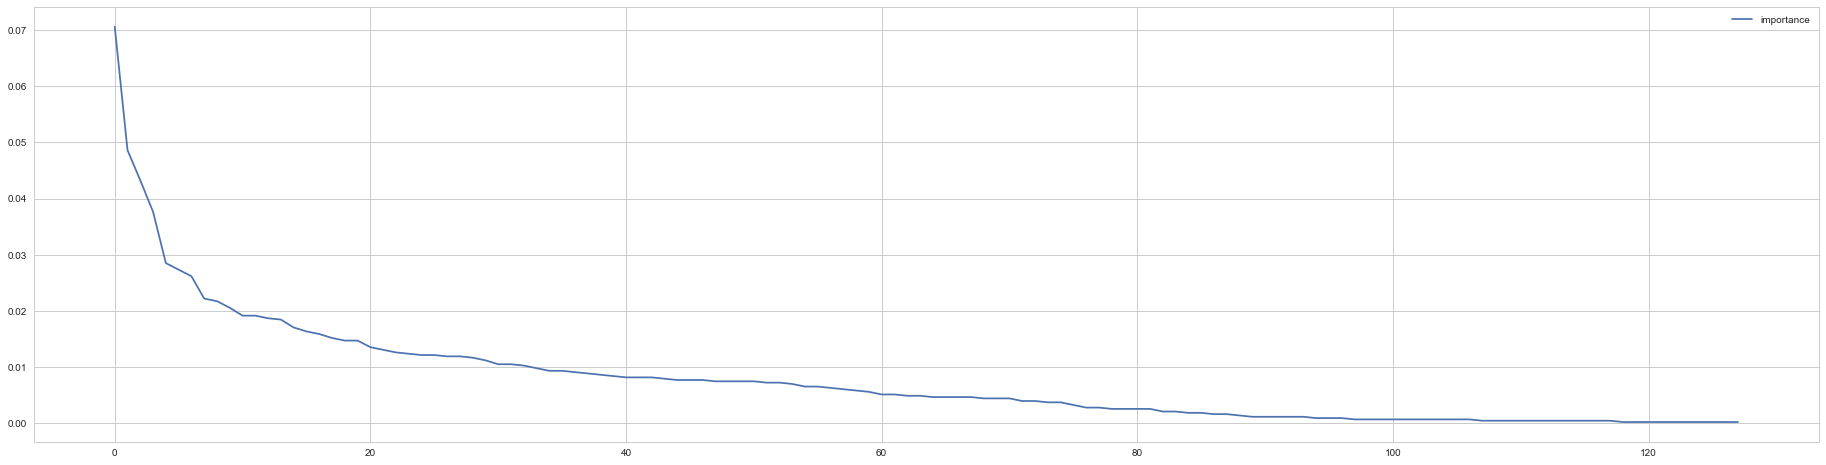

In [32]:
feature_importances_pos_df = feature_importances_df[feature_importances_df['importance'] > 0]
feature_importances_pos_df.plot(use_index=False, figsize=(32, 8))
plt.show()

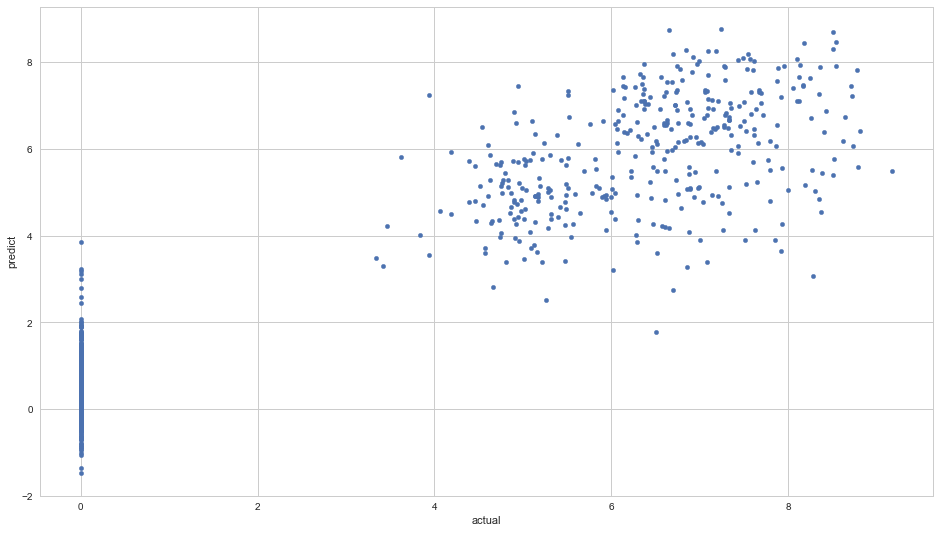

In [33]:
pd.DataFrame({'predict': stumps_sgbm.predict(CX_KI_WT_boruta_test), 
              'actual': CX_KI_WT_log_AB_test}).plot.scatter(x='actual', y='predict', figsize=(16, 9))

plt.show()

**Observation**
* as you can see in the plot above, the stumps undershoot the prediction for the WT entries. This hints at linear-like behaviour

In [34]:
feature_importances_pos_df.shape

(128, 2)

* the prioritized features, filtered down from the Boruta feature set

In [35]:
fine_genes = list(feature_importances_pos_df['gene'])

* reduce the train and test sets to only the fine features

In [36]:
CX_KI_WT_fine_train = CX_KI_WT_boruta[fine_genes].iloc[train_idx]
CX_KI_WT_fine_test = CX_KI_WT_boruta[fine_genes].iloc[test_idx]

In [37]:
CX_KI_WT_fine_train.shape

(3280, 128)

---

# **Deeper trees model**

* **!!! hunting for interactions !!!**
* so far we filtered the number of features down to 128
* we use this subset to build a deeper GBM model
* hyperparameter tuning of 2 parameters: `[max_depth]` and `[max_features]`

In [44]:
from scipy.stats.distributions import uniform as sp_uni, randint as sp_int
from sklearn.model_selection import RandomizedSearchCV

In [170]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

proto_sgbm = GradientBoostingRegressor(learning_rate=0.01, n_estimators=10000, subsample=0.9)

rs = RandomizedSearchCV(estimator=proto_sgbm,
                        n_iter=100,
                        cv=cv,
                        param_distributions={'max_depth':    sp_int(2, 14),
                                             'max_features': sp_uni(loc=0.1, scale=0.8)},
                        n_jobs=-1,                        
                        scoring='neg_mean_squared_error',
                        return_train_score=True)

In [ ]:
%%time
rs.fit(X=CX_KI_WT_fine_train,
       y=CX_KI_WT_log_AB_train,
       groups=CX_GT_train,
       monitor=EarlyStopMonitor())

In [172]:
rs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=12,
             max_features=0.3154340598690662, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=0.9, verbose=0,
             warm_start=False)

In [173]:
cv_results_df = pd.DataFrame(rs.cv_results_)
del cv_results_df['params']
cv_results_df = cv_results_df.apply(pd.to_numeric)

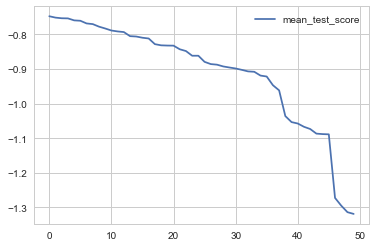

In [206]:
cv_results_df[['mean_test_score']].sort_values(by='mean_test_score', ascending=False).plot(use_index=False)
plt.show()

---

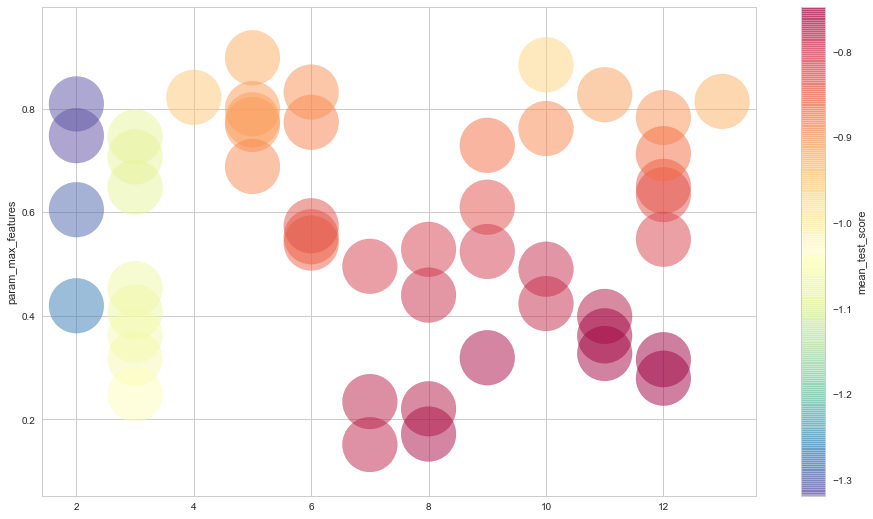

In [199]:
ax = cv_results_df.plot.scatter(x='param_max_depth',
                                y='param_max_features',
                                c='mean_test_score', 
                                s=3000,
                                alpha=0.5,
                                cmap='Spectral_r',
                                figsize=(16,9))

plt.setp(ax.get_xticklabels(), visible=True)
# plt.savefig('tuning.png')
plt.show()

* fit a model with tuned parameters

In [42]:
deep_sgbm = GradientBoostingRegressor(learning_rate=0.01, n_estimators=10000, max_depth=12, max_features=0.3, subsample=0.9, random_state=42)

In [43]:
# %%time
# deep_sgbm.fit(X=CX_KI_WT_fine_train,  
#               y=CX_KI_WT_log_AB_train,
#               monitor=EarlyStopMonitor())

stopped after rounds: 869
CPU times: user 2min 20s, sys: 945 ms, total: 2min 21s
Wall time: 2min 22s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=12, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10000, presort='auto', random_state=42,
             subsample=0.9, verbose=0, warm_start=False)

* save the model
* see: http://scikit-learn.org/stable/modules/model_persistence.html

In [45]:
from sklearn.externals import joblib

In [46]:
deep_sgbm_path = '09_results/deep_sgbm.pkl'

In [47]:
# joblib.dump(deep_sgbm, deep_sgbm_path)

['09_results/deep_sgbm.pkl']

In [50]:
deep_sgbm = joblib.load(deep_sgbm_path)

In [51]:
deep_sgbm_important_genes_df = pd.DataFrame({'gene': fine_genes, 'importance': deep_sgbm.feature_importances_}).sort_values(by='importance', ascending=False)

In [52]:
deep_sgbm_important_genes_df.head(20)

,gene,importance
3,Cst7,0.079386
0,Sez6,0.052305
16,Ctsd,0.050064
23,Gfap,0.034023
13,Ccl21c.1,0.030041
30,Tyrobp,0.020530
59,mt-Tm,0.018625
56,mt-Tl1,0.016349
12,Rpl12,0.015664
49,mt-Tf,0.014680


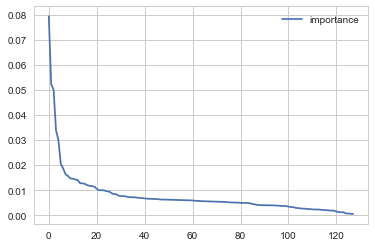

In [53]:
deep_sgbm_important_genes_df.plot(use_index=False)
plt.show()

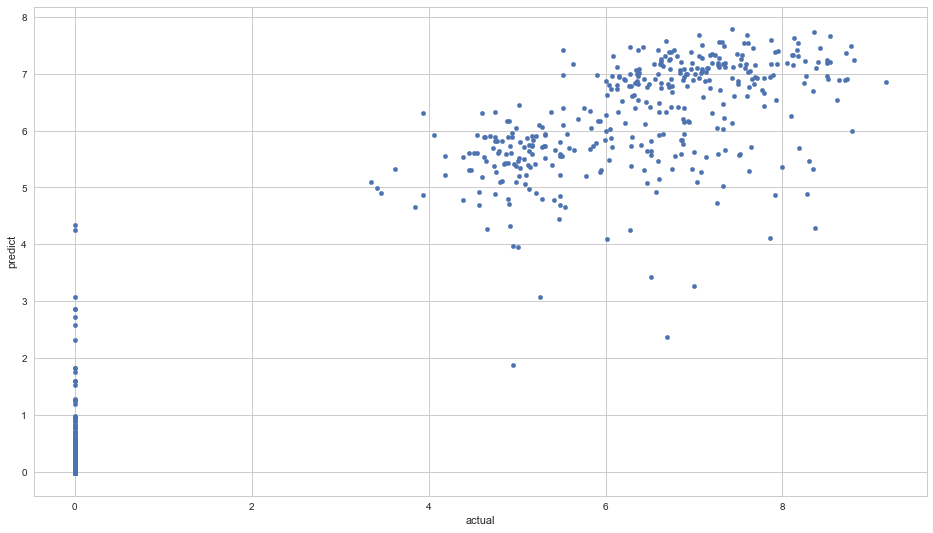

In [54]:
pd.DataFrame({'predict': deep_sgbm.predict(CX_KI_WT_fine_test), 
              'actual': CX_KI_WT_log_AB_test}).plot.scatter(x='actual', y='predict', figsize=(16, 9))

plt.show()

---

# **Process explanations**

* probably need some subsampling here...

In [213]:
def vectorize(explanation, length):
    vector = np.zeros(length)
    
    for idx, value in explanation.as_map()[1]:
        vector[idx] = value
    
    return vector

In [214]:
def remove_0_cols(df):
    return df.loc[:, (df !=0).any(axis=0)]

In [253]:
def to_explanations(X_train,
                    X_explain,
                    model,
                    feature_names=boruta_genes,
                    n_features=50,
                    seed=42):
    
    # TODO assertion
    assert len(feature_names) == X_explain.shape[1]
        
    explainer = LimeTabularExplainer(X_train,
                                     feature_names=feature_names,
                                     discretize_continuous=False,
                                     class_names=['log_AB'],
                                     mode='regression',
                                     # feature_selection='lasso_path',
                                     random_state=seed,
                                     verbose=False)
    
    vec_explanations = []
    
    df = X_explain
    
    for idx in df.index:        
        e = explainer.explain_instance(df.loc[idx], model.predict, num_features=n_features)
        v = vectorize(e, df.shape[1])
            
        vec_explanations.append(v)
    
    explanations_df = pd.DataFrame(vec_explanations)    
    explanations_df.columns = feature_names
    explanations_df.index = df.index
    
    return explanations_df

In [60]:
def to_explanation_box_plots(explanations_df,
                             figsize=(30, 8)):
    
    mean_weights_df = pd.DataFrame(explanations_df.mean(axis=0)).reset_index()
    mean_weights_df.columns = ['gene', 'mean']
    mean_weights_df['abs_mean'] = mean_weights_df['mean'].abs()
    
    ordering = list(mean_weights_df.sort_values(by='abs_mean', ascending=False)['gene'])
    
    print(ordering)
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=90)
    sns.boxplot(data=explanations_df.melt(), x='variable', y='value', ax=ax, order=ordering)
    plt.show()

In [255]:
# %%time
# explanations_df = to_explanations(X_train=CX_KI_WT_boruta_train[fine_genes],
#                                   X_explain=CX_KI_WT_boruta[fine_genes].sample(frac=0.1),
#                                   model=deep_sgbm,
#                                   feature_names=fine_genes,
#                                   n_features=len(fine_genes))

CPU times: user 13min 26s, sys: 30min 3s, total: 43min 29s
Wall time: 3min 41s


In [55]:
log_AB_explanations_path = '09_results/explanations_log_AB.tsv'

In [56]:
# explanations_df.to_csv(log_AB_explanations_path, sep='\t')

In [57]:
explanations_df = pd.read_csv(log_AB_explanations_path, sep='\t', index_col=0)

In [58]:
explanations_df.head()

,Sez6,Tbx1,Gm45212,Cst7,Fzd5,Dao,Hsh2d,mt-Atp6,Kif15,Gm26917,...,mt-Te,Hexb,mt-Atp8,Ifi27l2a,Sptan1,Dlgap3,Mir6240,Wdr6,C1qa,Rn18s-rs5
9494,-0.276399,0.007674,0.040920,0.631955,0.026155,-0.014466,0.003909,-0.016289,-0.038928,-0.065422,...,0.019925,0.013451,0.014041,0.000092,-0.006933,-0.021406,-0.001855,-0.015655,0.048182,0.002815
6477,-0.257654,0.084031,0.031087,0.591373,0.015956,0.023104,-0.010517,-0.044486,-0.017722,-0.027422,...,-0.012539,0.038150,0.031531,0.002442,0.022663,-0.000224,0.015142,-0.007876,0.007688,0.031294
6008,-0.299737,0.021899,-0.007839,0.627908,0.005600,0.000789,0.004687,-0.024921,-0.041218,-0.073257,...,0.039481,0.030075,-0.014791,0.019512,-0.031103,-0.027416,0.018349,-0.002773,0.025308,-0.019234
2317,-0.272396,0.035774,0.011979,0.618798,0.014299,0.008421,0.008001,-0.027455,-0.023972,-0.064703,...,0.033134,0.023058,0.011289,-0.014465,0.032067,-0.003603,-0.019742,-0.003101,0.054602,-0.003014
564,-0.298735,0.037938,-0.003570,0.637773,0.014475,-0.016931,-0.038244,-0.018826,-0.014945,-0.042097,...,-0.006544,0.019677,0.012641,0.013955,-0.002157,0.000094,0.006578,0.003359,0.032310,-0.016328


['Ccl21c.1', 'Cst7', 'Sez6', 'Gfap', 'Ctsd', 'mt-Rnr1', 'Cst3', 'Lrrc17', 'Gm28437', 'mt-Rnr2', 'Tyrobp', 'Rpl12', 'mt-Tm', 'mt-Tl1', 'Gm26917', 'B2m', 'mt-Tv', 'mt-Tl2', 'Lyz2', 'Ctss', 'Trem2', 'Kif15', 'C1qa', 'Gm20594', 'Gm11033', 'Gm14303', 'Rplp1', 'Hexb', 'Gm7079', 'mt-Ta', 'Olfr912', 'Gm42418', 'C4b', 'mt-Tp', 'mt-Atp6', 'C1qb', 'Uba52', 'Lars2', 'mt-Tf', 'Rpl41', 'mt-Tq', 'Rps16', 'mt-Th', 'Tbx1', 'mt-Tc', 'Clec7a', 'Gm10736', 'Gm3511', 'Fth1', '2810433D01Rik', 'Cd74', 'Gm43841', 'Rps21', 'mt-Te', 'mt-Co2', 'Arc', 'Rps12', 'Mbp', 'Rplp2', 'Ccl6', 'Serpina3n', 'Gm43743', 'Gm28439', 'Ccl21a', 'C4a', 'Rpl30', 'mt-Atp8', 'Glul', 'Gm15728', 'Rps23', 'Taco1os', 'Ccl21c', 'Ctsz', 'Atp6v1b2', 'Cd9', 'Ly86', 'Cox8a', 'Olfr912.1', 'Dlgap3', 'Gm11425', 'Hsh2d', 'Ttr', 'Nr4a1', 'RP23-70B19.5', 'C1qc', 'Cd68', 'Entpd4', 'Dao', 'Gtf2h1', 'Sept5', 'Rps27a', 'Tpt1', 'Gm27177', 'Eno1b', 'Gm20430', 'Rn18s-rs5', 'Gm28438', 'Gpr55', 'Olfr685', 'Mir6240', 'Fzd5', 'Gm14859', 'Gm21685', 'Plp1', 'Gm4

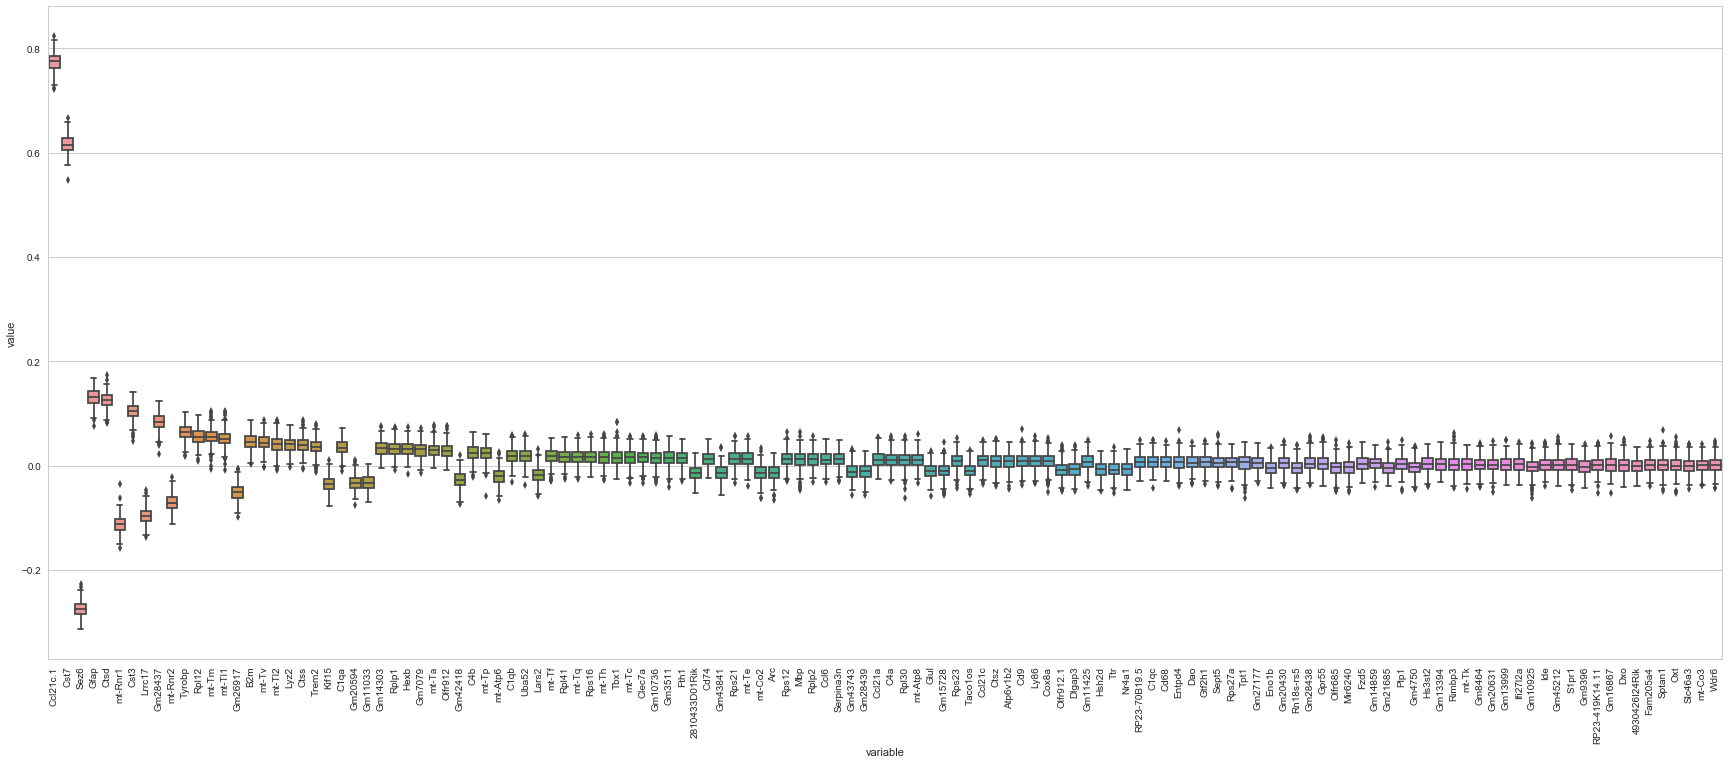

In [61]:
to_explanation_box_plots(explanations_df, figsize=(30, 12))

* TODO: make the function return this ordering

In [70]:
fine_genes_by_explanation_weight = ['Ccl21c.1', 'Cst7', 'Sez6', 'Gfap', 'Ctsd', 'mt-Rnr1', 'Cst3', 'Lrrc17', 'Gm28437', 'mt-Rnr2', 'Tyrobp', 'Rpl12', 'mt-Tm', 'mt-Tl1', 'Gm26917', 'B2m', 'mt-Tv', 'mt-Tl2', 'Lyz2', 'Ctss', 'Trem2', 'Kif15', 'C1qa', 'Gm20594', 'Gm11033', 'Gm14303', 'Rplp1', 'Hexb', 'Gm7079', 'mt-Ta', 'Olfr912', 'Gm42418', 'C4b', 'mt-Tp', 'mt-Atp6', 'C1qb', 'Uba52', 'Lars2', 'mt-Tf', 'Rpl41', 'mt-Tq', 'Rps16', 'mt-Th', 'Tbx1', 'mt-Tc', 'Clec7a', 'Gm10736', 'Gm3511', 'Fth1', '2810433D01Rik', 'Cd74', 'Gm43841', 'Rps21', 'mt-Te', 'mt-Co2', 'Arc', 'Rps12', 'Mbp', 'Rplp2', 'Ccl6', 'Serpina3n', 'Gm43743', 'Gm28439', 'Ccl21a', 'C4a', 'Rpl30', 'mt-Atp8', 'Glul', 'Gm15728', 'Rps23', 'Taco1os', 'Ccl21c', 'Ctsz', 'Atp6v1b2', 'Cd9', 'Ly86', 'Cox8a', 'Olfr912.1', 'Dlgap3', 'Gm11425', 'Hsh2d', 'Ttr', 'Nr4a1', 'RP23-70B19.5', 'C1qc', 'Cd68', 'Entpd4', 'Dao', 'Gtf2h1', 'Sept5', 'Rps27a', 'Tpt1', 'Gm27177', 'Eno1b', 'Gm20430', 'Rn18s-rs5', 'Gm28438', 'Gpr55', 'Olfr685', 'Mir6240', 'Fzd5', 'Gm14859', 'Gm21685', 'Plp1', 'Gm4750', 'Hs3st2', 'Gm13394', 'Rimbp3', 'mt-Tk', 'Gm8464', 'Gm20631', 'Gm13999', 'Ifi27l2a', 'Gm10925', 'Ide', 'Gm45212', 'S1pr1', 'Gm9396', 'RP23-419K14.11', 'Gm16867', 'Dxo', '4930426I24Rik', 'Fam205a4', 'Sptan1', 'Oxt', 'Slc46a3', 'mt-Co3', 'Wdr6']

# **Explanation space embedding**

Figure out if there is structure in the space of LIME explanations.

In [71]:
explanations_df.head()

,Sez6,Tbx1,Gm45212,Cst7,Fzd5,Dao,Hsh2d,mt-Atp6,Kif15,Gm26917,...,mt-Te,Hexb,mt-Atp8,Ifi27l2a,Sptan1,Dlgap3,Mir6240,Wdr6,C1qa,Rn18s-rs5
9494,-0.276399,0.007674,0.040920,0.631955,0.026155,-0.014466,0.003909,-0.016289,-0.038928,-0.065422,...,0.019925,0.013451,0.014041,0.000092,-0.006933,-0.021406,-0.001855,-0.015655,0.048182,0.002815
6477,-0.257654,0.084031,0.031087,0.591373,0.015956,0.023104,-0.010517,-0.044486,-0.017722,-0.027422,...,-0.012539,0.038150,0.031531,0.002442,0.022663,-0.000224,0.015142,-0.007876,0.007688,0.031294
6008,-0.299737,0.021899,-0.007839,0.627908,0.005600,0.000789,0.004687,-0.024921,-0.041218,-0.073257,...,0.039481,0.030075,-0.014791,0.019512,-0.031103,-0.027416,0.018349,-0.002773,0.025308,-0.019234
2317,-0.272396,0.035774,0.011979,0.618798,0.014299,0.008421,0.008001,-0.027455,-0.023972,-0.064703,...,0.033134,0.023058,0.011289,-0.014465,0.032067,-0.003603,-0.019742,-0.003101,0.054602,-0.003014
564,-0.298735,0.037938,-0.003570,0.637773,0.014475,-0.016931,-0.038244,-0.018826,-0.014945,-0.042097,...,-0.006544,0.019677,0.012641,0.013955,-0.002157,0.000094,0.006578,0.003359,0.032310,-0.016328


In [72]:
%%time
umap_embedding = UMAP(metric='manhattan', random_state=42).fit_transform(explanations_df)

CPU times: user 1.79 s, sys: 942 ms, total: 2.73 s
Wall time: 1.65 s


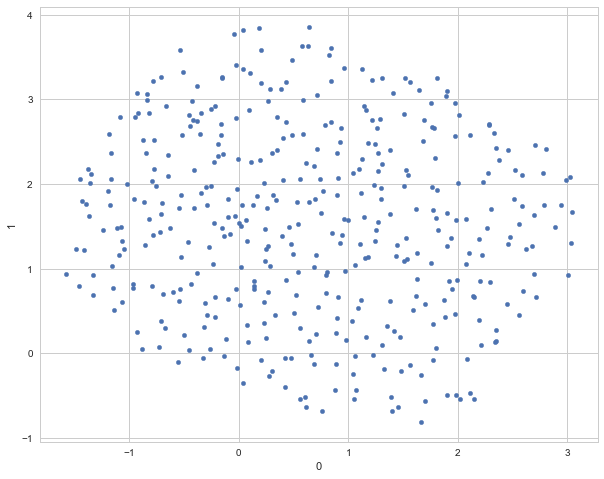

In [73]:
pd.DataFrame(umap_embedding).plot.scatter(x=0, y=1, figsize=(10, 8)) #, alpha=0.5, c=CX_KI_WT_log_AB_test, cmap='inferno')
plt.show()

---

# Embedding by the genes with highest explanation weight

In [106]:
top_genes_BAK = fine_genes_by_explanation_weight[:16]
top_genes = list(deep_sgbm_important_genes_df['gene'])[:20]

In [109]:
%%time
cx_umap_explanation_embedding = UMAP(spread=2, metric='manhattan').fit_transform(KI_WT_region_sets['CX'][top_genes])

CPU times: user 18.6 s, sys: 9.95 s, total: 28.5 s
Wall time: 17.4 s


In [110]:
# %%time
# cx_tsne_explanation_embedding = TSNE().fit_transform(KI_WT_region_sets['CX'][top_genes])

In [111]:
Cst7 = KI_WT_region_sets['CX']['Cst7']
Sez6 = KI_WT_region_sets['CX']['Sez6']

log_AB = KI_WT_region_sets['CX']['log_AB']
GT = KI_WT_region_sets['CX']['GT'].cat.codes
age = KI_WT_region_sets['CX']['age'].cat.codes
age_GT = KI_WT_region_sets['CX']['age_GT'].cat.codes
slide = KI_WT_region_sets['CX']['slide_ID'].cat.codes

In [112]:
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#34495e", "#2ecc71"]
my_cmap = ListedColormap(sns.color_palette(flatui[:4]).as_hex())

### Color by GT

* green = WT
* dark = KI

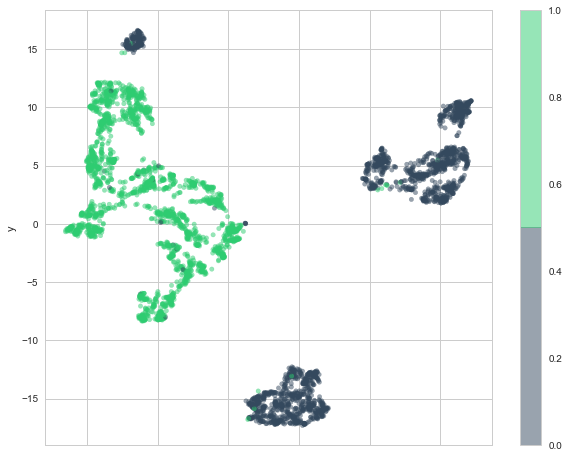

In [113]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=GT, alpha=0.5, cmap=my_cmap, figsize=(10,8))
plt.show()

### Color by age

* green = young
* dark = old

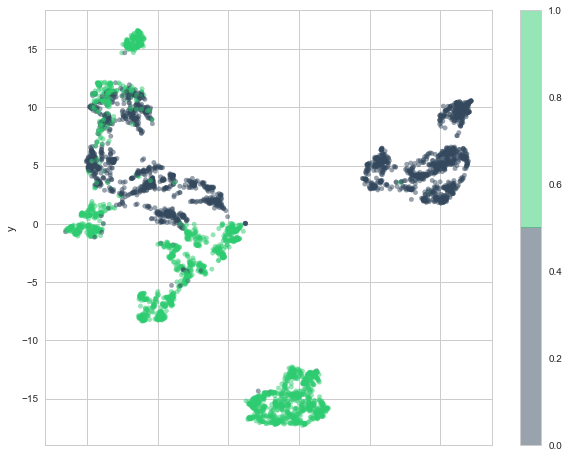

In [114]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=age, alpha=0.5, cmap=my_cmap, figsize=(10,8))
plt.show()

### Color by log(AB)

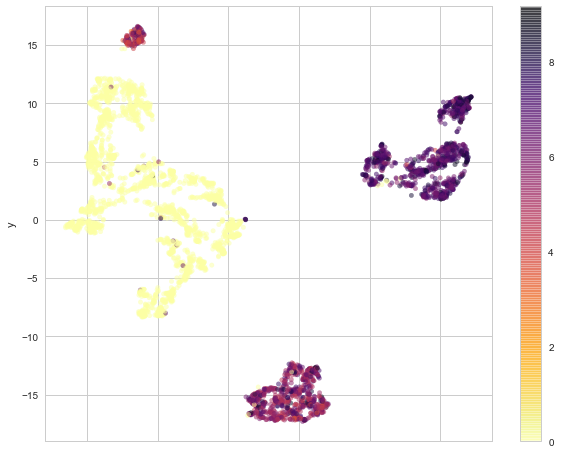

In [115]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=log_AB, alpha=0.5, cmap='inferno_r', figsize=(10,8))
plt.show()

### Color by slide_ID

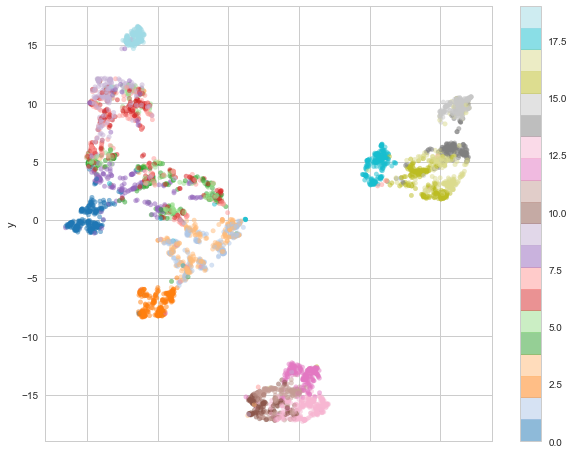

In [116]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=slide, alpha=0.5, cmap='tab20', figsize=(10,8))
plt.show()

# Matrix of embedding colorings

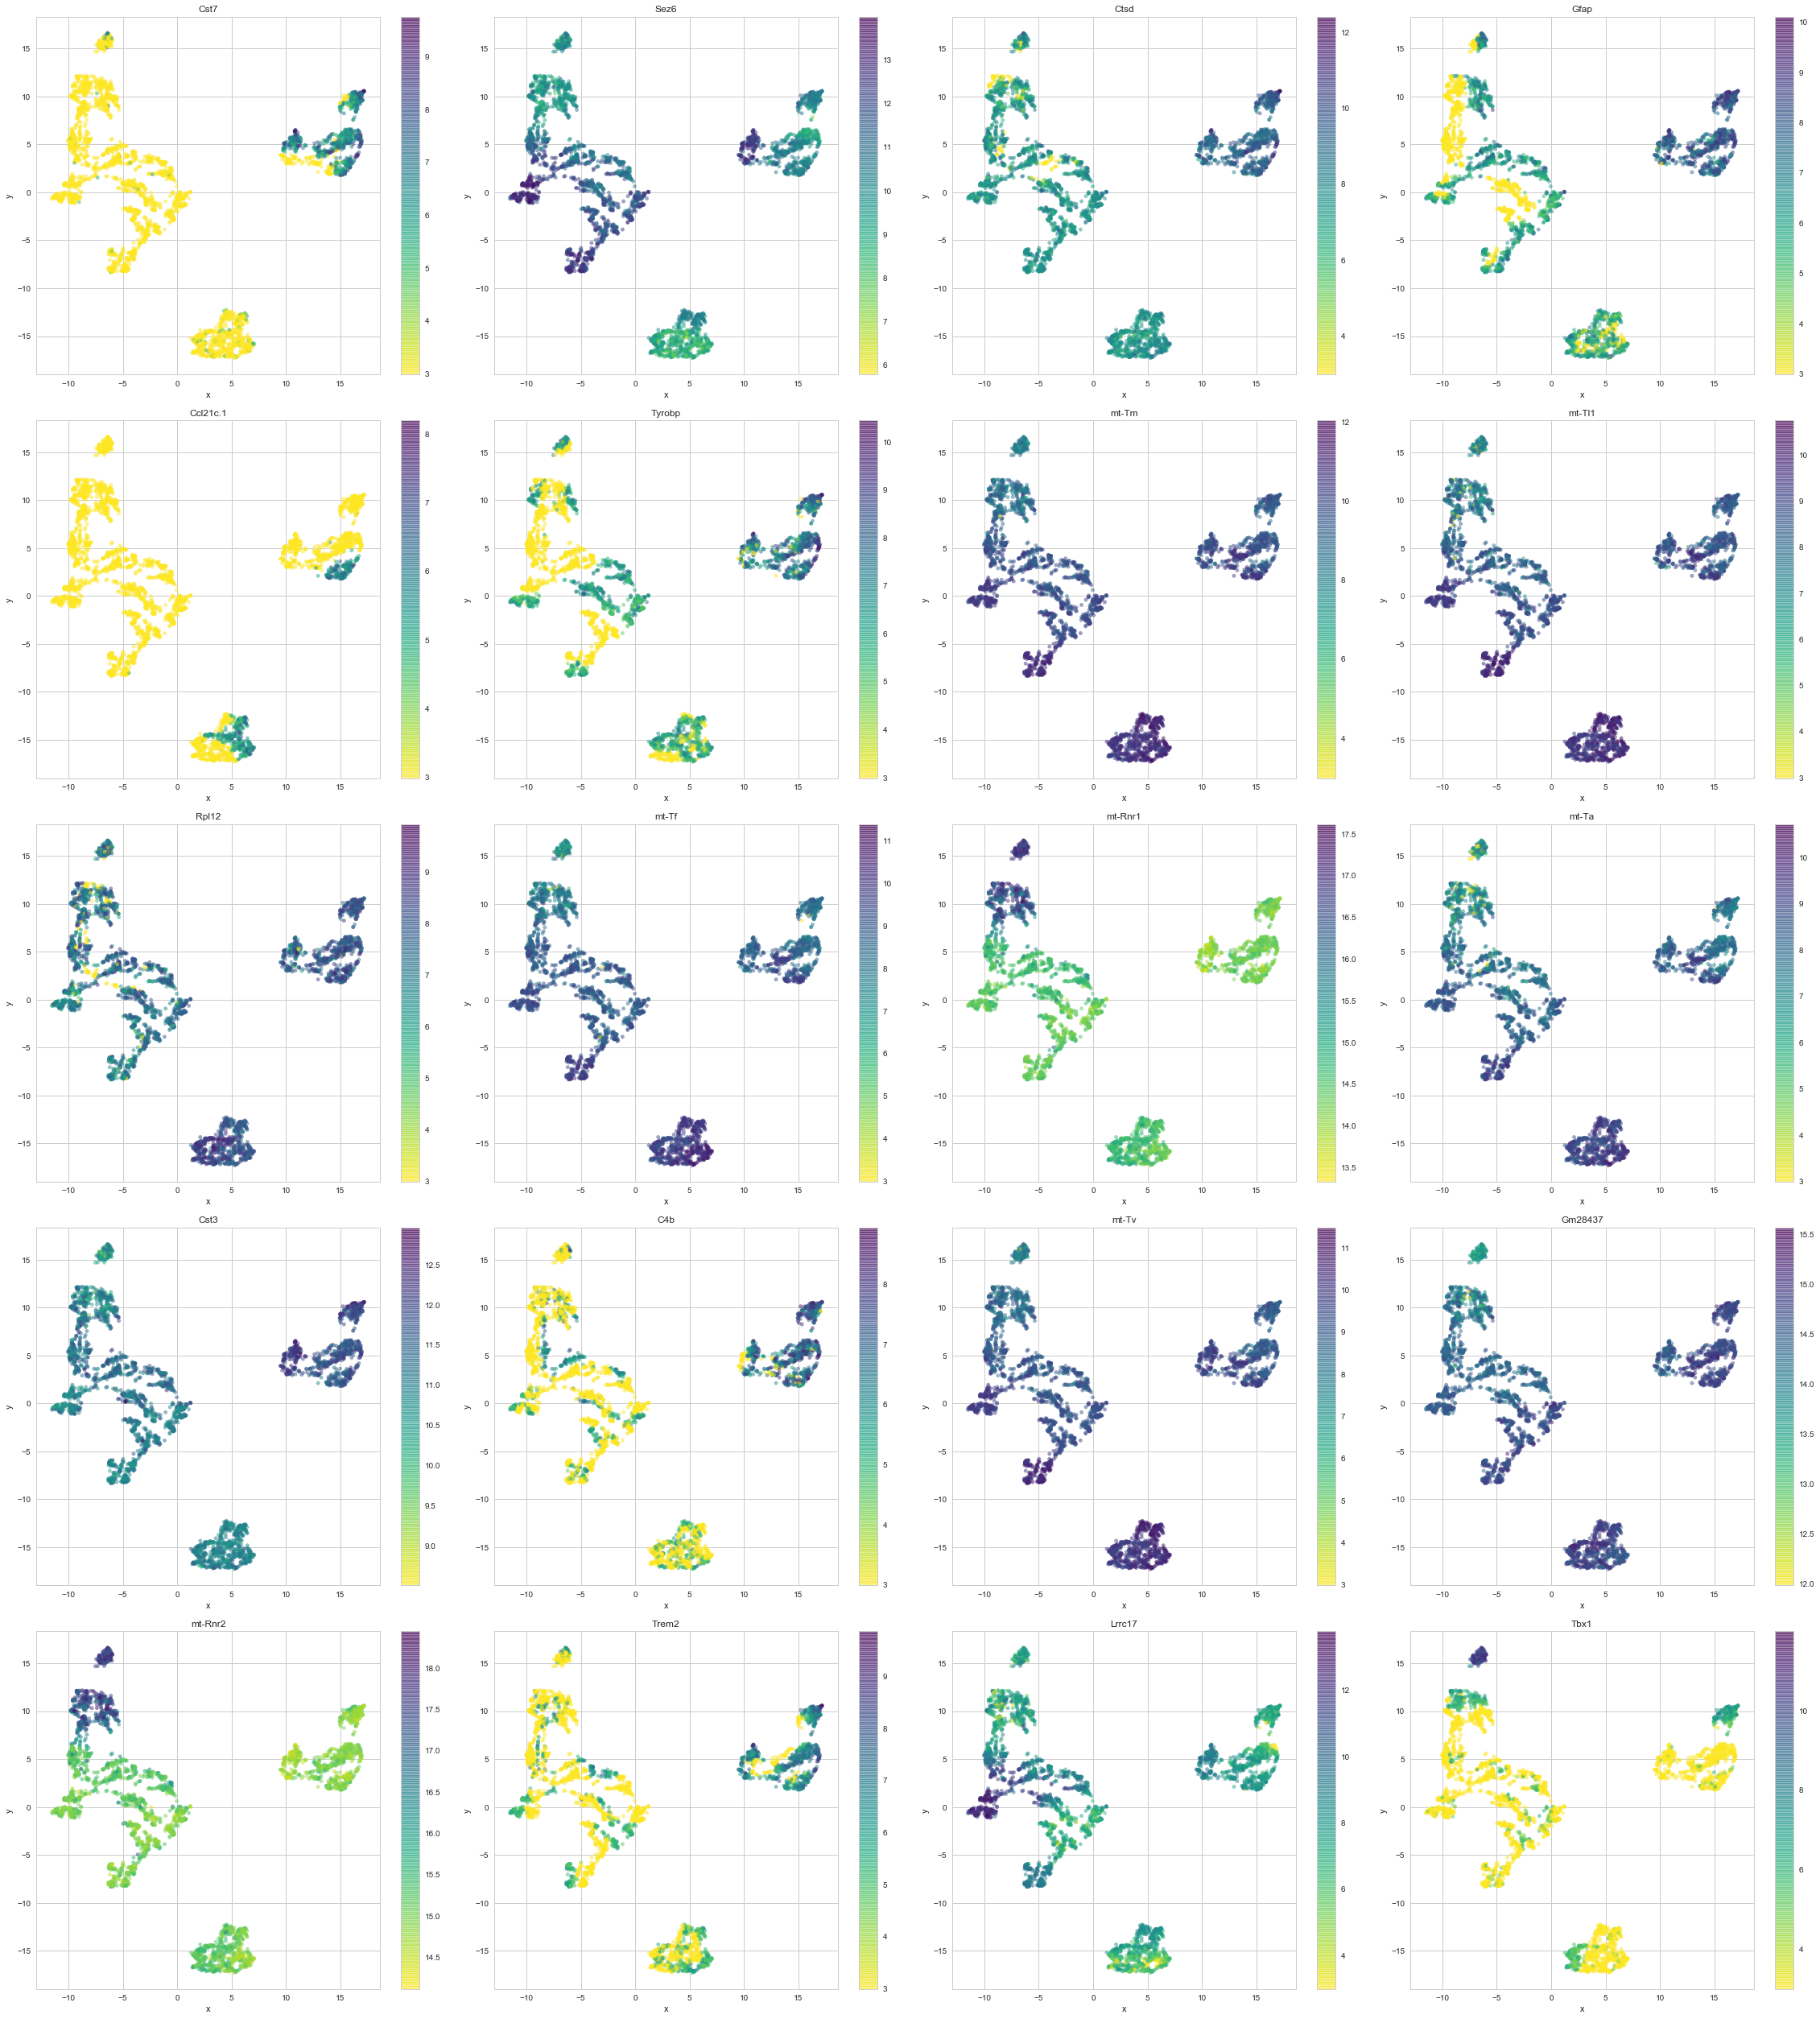

In [117]:
cx_df = pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y'])

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(32,35))

for i, gene in enumerate(top_genes):
    ax = axes.flat[i]
    ax.title.set_text(gene)
    
    gene_coloring = KI_WT_region_sets['CX'][gene]
    
    g = cx_df.plot.scatter(x='x', y='y', ax=ax,
                           c=gene_coloring, 
                           cmap='viridis_r', 
                           alpha=0.5)

plt.tight_layout()
plt.show()